# GP

In [1]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %matplotlib inline
#%matplotlib widget


# Setup environment collect data

In [9]:
# =========================================================
# Cell 1 — MonsterTruck environment setup (MuJoCo, radians)
# Utilities, constants, and policies ONLY (no collection here)
# =========================================================
import os, math, time
import numpy as np
import mujoco

# ------------------- Global config -------------------
SEED = 0
rng = np.random.default_rng(SEED)

XML_PATH   = "monstertruck.xml"   # update if needed
FRAME_SKIP = 10                   # sim steps per control
ACTION_LOW, ACTION_HIGH = -1.0, 1.0

# Sign convention: + when pitching toward the head direction
PITCH_SIGN = +1   # flip to -1 if your model's "forward" comes out negative

# Success hysteresis (now in radians)
SUCCESS_ENTER_RAD    = np.deg2rad(178.0)
SUCCESS_RELEASE_RAD  = np.deg2rad(176.5)
MAX_UPRIGHT_RATE_RAD = np.deg2rad(60.0)
HOLD_NEEDED          = 2

# ------------------- Angle helpers (radians) -------------------
def clip(v, lo, hi):
    return lo if v < lo else (hi if v > hi else v)

def angdiff_rad(curr, prev):
    """Minimal signed angle diff in radians, (-pi, pi]."""
    return ((curr - prev + np.pi) % (2.0 * np.pi)) - np.pi

def get_signed_flip_rad(data, body_id, roof_is_neg_z=True):
    """
    Signed flip angle φ [rad] with your convention:
      0 = upside-down, ±π = upright.
      Positive when pitching toward the head (forward), negative otherwise.

    Numerically-stable via atan2(||z×r||, z·r). Sign from (z×r)·y (about pitch axis).
    """
    R = data.xmat[body_id].reshape(3, 3)     # body->world rotation
    z_w = np.array([0.0, 0.0, 1.0], float)   # world up

    body_z_world = R[:, 2]
    r_w = -body_z_world if roof_is_neg_z else body_z_world  # roof normal in world
    y_w =  R[:, 1]  # body Y (pitch axis) expressed in world

    v = np.cross(z_w, r_w)                   # perpendicular to both
    c = float(np.dot(z_w, r_w))              # cos-like term
    s_axis = float(np.dot(v, y_w))           # sign wrt pitch axis (forward/backward)
    theta = math.atan2(np.linalg.norm(v), clip(c, -1.0, 1.0))  # [0, π] in radians

    # Persistent sign memory to avoid flicker near 0
    if not hasattr(get_signed_flip_rad, "_flip_sign"):
        get_signed_flip_rad._flip_sign = 0.0
    if theta > np.deg2rad(0.5) and abs(s_axis) > 1e-12:
        get_signed_flip_rad._flip_sign = 1.0 if (PITCH_SIGN * s_axis) > 0.0 else -1.0

    sgn = get_signed_flip_rad._flip_sign if get_signed_flip_rad._flip_sign != 0.0 else 1.0
    return sgn * theta

# ------------------- Reset / control helpers -------------------
def reset_state(model, data):
    """Upside-down spawn with tiny jitter."""
    mujoco.mj_resetData(model, data)
    data.qpos[:3] = np.array([0.0, 0.0, 0.3]) + 0.01 * rng.normal(size=3)
    data.qvel[:]  = 0.0
    data.qpos[3:7] = np.array([0.0, 1.0, 0.0, 0.0])  # 180° about X (upside-down)
    mujoco.mj_forward(model, data)
    # reset flip-sign memory
    get_signed_flip_rad._flip_sign = 0.0

def find_throttle_ids(model):
    ids = []
    for name in ["front_left_motor", "front_right_motor",
                 "rear_left_motor", "rear_right_motor"]:
        aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
        if aid != -1:
            ids.append(aid)
    if not ids:
        ids = list(range(model.nu))  # fallback: drive all actuators
    return ids

def apply_throttle(data, ids, u):
    if data.ctrl is not None and data.ctrl.size > 0:
        data.ctrl[:] = 0.0
        for aid in ids:
            data.ctrl[aid] = u

# ------------------- Continuous policies (use radians) -------------------
def random_policy():
    return float(rng.uniform(ACTION_LOW, ACTION_HIGH))

def swing_cont_policy(phi_rad, omega_rad, k=0.7, bias=0.0, noise_std=0.15):
    """
    Continuous 'swing' throttle (radians):
      - scales with angular rate via tanh(·)
      - optional small Gaussian exploration
    Returns: float in [-1, 1]
    """
    base = k * np.tanh(omega_rad / 3.0) + bias * np.sign(omega_rad)
    a = base + noise_std * rng.normal()
    return float(np.clip(a, ACTION_LOW, ACTION_HIGH))


# Dynamics from GP

In [10]:
# =========================================================
# Cell 2 — Data collection (radians, no plotting)
# Produces:
#   phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s
# =========================================================
import os
import numpy as np
import mujoco

TOTAL_STEPS   = 100_000
USE_POLICY    = ["swing_cont", "random"]   # or just ["swing_cont"]
USE_BOTH_DATA = False                       # True => split steps across policies

def _to_scalar(a):
    """Robustly convert action to a scalar float even if it's (val,) or [val]."""
    try:
        return float(a)
    except (TypeError, ValueError):
        arr = np.asarray(a).reshape(-1)
        if arr.size == 0:
            return 0.0
        return float(arr[0])

def collect(n_steps=TOTAL_STEPS, use_policies=USE_POLICY, use_both=USE_BOTH_DATA):
    if not os.path.exists(XML_PATH):
        raise FileNotFoundError(f"Cannot find {XML_PATH}.")
    model = mujoco.MjModel.from_xml_path(XML_PATH)
    data  = mujoco.MjData(model)
    dt = model.opt.timestep if model.opt.timestep > 0 else 0.001

    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
    if body_id == -1:
        raise RuntimeError("Body 'chassis' not found in XML.")
    throttle_ids = find_throttle_ids(model)

    phi, omg, act, dphi, domg = [], [], [], [], []

    def run_once(policy_name, n=n_steps):
        reset_state(model, data)

        # Prime φ & ω with a zero-action macro step
        phi_prev = get_signed_flip_rad(data, body_id)
        apply_throttle(data, throttle_ids, 0.0)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)
        phi_now = get_signed_flip_rad(data, body_id)
        omega_prev = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
        phi_prev = phi_now

        hold = 0
        for _ in range(n):
            if policy_name == "swing_cont":
                a = swing_cont_policy(phi_prev, omega_prev)
            elif policy_name == "random":
                a = random_policy()
            else:
                raise ValueError(f"Unknown policy: {policy_name}")

            a = _to_scalar(a)  # ensure float scalar in [-1,1]

            apply_throttle(data, throttle_ids, a)
            for _ in range(FRAME_SKIP):
                mujoco.mj_step(model, data)

            phi_now = get_signed_flip_rad(data, body_id)
            omega_now = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)

            # log sample (state, action, deltas) — all in radians
            phi.append(float(phi_prev))
            omg.append(float(omega_prev))
            act.append(float(a))
            dphi.append(float(angdiff_rad(phi_now, phi_prev)))
            domg.append(float(omega_now - omega_prev))

            # success hysteresis + velocity gate → reset for diverse data (radians)
            if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omega_now) <= MAX_UPRIGHT_RATE_RAD):
                hold += 1
            elif abs(phi_now) < SUCCESS_RELEASE_RAD:
                hold = 0
            if hold >= HOLD_NEEDED:
                reset_state(model, data)
                phi_prev = get_signed_flip_rad(data, body_id)
                omega_prev = 0.0
                hold = 0
                continue

            # slide window
            phi_prev, omega_prev = phi_now, omega_now

    if use_both and isinstance(use_policies, (list, tuple)) and len(use_policies) >= 1:
        steps_each = n_steps // max(1, len(use_policies))
        for p in use_policies:
            run_once(p, steps_each)
    else:
        p = use_policies[0] if isinstance(use_policies, (list, tuple)) else use_policies
        run_once(p, n_steps)

    # numpy arrays for GP / plotting (radians)
    phi_arr  = np.asarray(phi,  dtype=np.float32)
    omg_arr  = np.asarray(omg,  dtype=np.float32)
    act_arr  = np.asarray(act,  dtype=np.float32)
    dphi_arr = np.asarray(dphi, dtype=np.float32)
    domg_arr = np.asarray(domg, dtype=np.float32)
    return phi_arr, omg_arr, act_arr, dphi_arr, domg_arr

# Run collection once so the viz/GP cells can use the arrays
phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s = collect()

print("Collected (radians):",
      "phi_rad",        phi_rad.shape,
      "omega_rad_s",    omega_rad_s.shape,
      "act",            act.shape,
      "dphi_rad",       dphi_rad.shape,
      "domega_rad_s",   domega_rad_s.shape)


Collected (radians): phi_rad (100000,) omega_rad_s (100000,) act (100000,) dphi_rad (100000,) domega_rad_s (100000,)


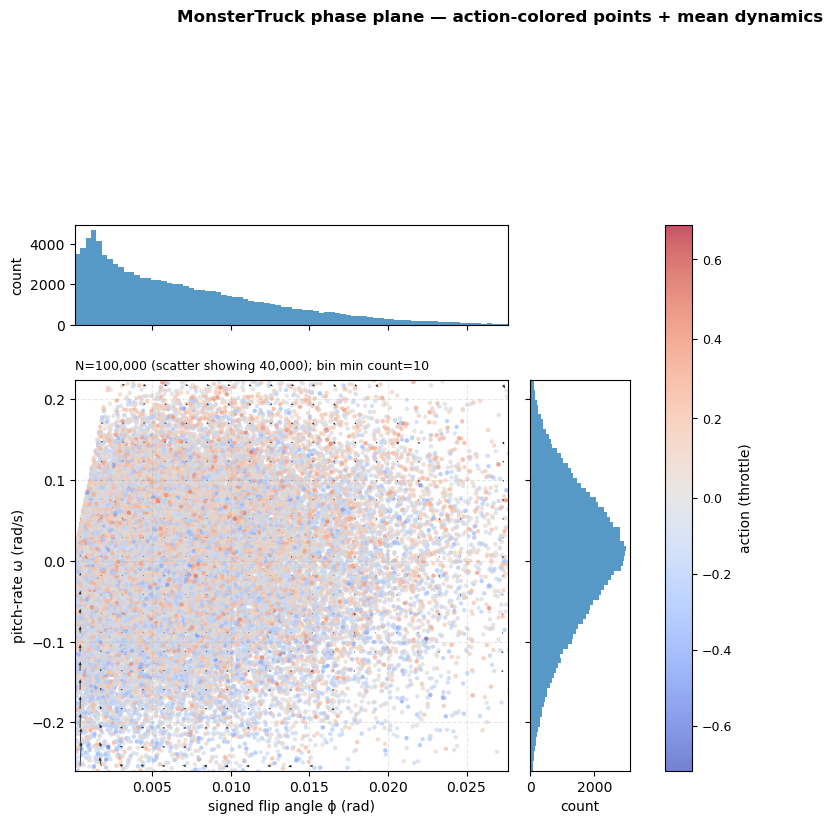

In [15]:
# =========================================================
# Cell 3 — Phase plane viz (radians) — fixed titles & bigger top gap
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ---------- Tunables ----------
BINS_PHI     = 41
BINS_OMEGA   = 41
ARROW_STRIDE = 2
MIN_BIN_CNT  = 10
MAX_POINTS   = 40_000
DENS_BINS    = (80, 80)
Q_LO, Q_HI   = 0.5, 99.5

# Asymmetric spacing (push top histogram farther up)
PAD_TOP    = 0.55   # increase to move the TOP histogram even higher
PAD_RIGHT  = 0.22
HEIGHT_TOP = 1.0
WIDTH_RIGHT= 1.0

# Figure margins & colorbar pad; we also leave space for a suptitle
FIG_LEFT, FIG_RIGHT, FIG_BOTTOM, FIG_TOP = 0.08, 0.92, 0.10, 0.92
CBAR_PAD = 0.05

TITLE = "MonsterTruck phase plane — action-colored points + mean dynamics"
SUCCESS_ENTER = globals().get("SUCCESS_ENTER_RAD", np.deg2rad(178.0))

# ---------- Robust ranges ----------
phi_lo, phi_hi = np.percentile(phi_rad,     [Q_LO, Q_HI])
omg_lo, omg_hi = np.percentile(omega_rad_s, [Q_LO, Q_HI])

# ---------- 2D density background ----------
H, xedges, yedges = np.histogram2d(
    phi_rad, omega_rad_s, bins=DENS_BINS, range=[[phi_lo, phi_hi], [omg_lo, omg_hi]]
)
H = H.T

fig = plt.figure(figsize=(11.2, 8.8))
fig.subplots_adjust(left=FIG_LEFT, right=FIG_RIGHT, bottom=FIG_BOTTOM, top=FIG_TOP)
fig.suptitle(TITLE, y=0.985, fontsize=12, fontweight="bold")  # <-- put title at figure level

# Main axis
ax = fig.add_axes([0.12, 0.12, 0.62, 0.62])
ax.pcolormesh(xedges, yedges, H, shading="auto", cmap="Greys", alpha=0.15)

# Scatter (downsample if huge)
N = phi_rad.shape[0]
idx = np.random.default_rng(0).choice(N, size=MAX_POINTS, replace=False) if N > MAX_POINTS else slice(None)
norm = TwoSlopeNorm(vcenter=0.0, vmin=float(act.min()), vmax=float(act.max()))
pts = ax.scatter(
    phi_rad[idx], omega_rad_s[idx],
    c=act[idx], s=10, cmap="coolwarm", norm=norm, edgecolors="none", alpha=0.7
)

# Quiver: mean (Δφ, Δω) per bin
phi_edges = np.linspace(phi_lo, phi_hi, BINS_PHI + 1)
omg_edges = np.linspace(omg_lo, omg_hi, BINS_OMEGA + 1)
phi_centers = 0.5 * (phi_edges[:-1] + phi_edges[1:])
omg_centers = 0.5 * (omg_edges[:-1] + omg_edges[1:])

sum_dphi = np.zeros((BINS_PHI, BINS_OMEGA), dtype=np.float64)
sum_domg = np.zeros_like(sum_dphi)
count    = np.zeros_like(sum_dphi)

phi_idx = np.clip(np.digitize(phi_rad,     phi_edges) - 1, 0, BINS_PHI   - 1)
omg_idx = np.clip(np.digitize(omega_rad_s, omg_edges) - 1, 0, BINS_OMEGA - 1)
for i in range(phi_idx.size):
    sum_dphi[phi_idx[i], omg_idx[i]] += dphi_rad[i]
    sum_domg[phi_idx[i], omg_idx[i]] += domega_rad_s[i]
    count[phi_idx[i], omg_idx[i]]    += 1

mask = count >= MIN_BIN_CNT
U = np.zeros_like(sum_dphi); V = np.zeros_like(sum_dphi)
U[mask] = sum_dphi[mask] / count[mask]
V[mask] = sum_domg[mask] / count[mask]

sel = (np.arange(BINS_PHI)   % ARROW_STRIDE == 0)[:, None] & \
      (np.arange(BINS_OMEGA) % ARROW_STRIDE == 0)[None, :] & mask

mag = np.hypot(U[sel], V[sel])
p95 = np.percentile(mag[mag > 0], 95) if np.any(mag > 0) else 1.0
desired_len = 0.12 * (phi_hi - phi_lo)
quiver_scale = (p95 / desired_len) if p95 > 0 else 1.0

Xg, Yg = np.meshgrid(phi_centers, omg_centers, indexing="ij")
ax.quiver(
    Xg[sel], Yg[sel], U[sel], V[sel],
    angles="xy", scale_units="xy", scale=quiver_scale,
    width=0.002, headwidth=3.5, headlength=4.5, headaxislength=4.0,
    color="k", alpha=0.85
)

# Success band shading
ax.axvspan(SUCCESS_ENTER,  np.pi, color="#ffd54f", alpha=0.12, linewidth=0)
ax.axvspan(-np.pi, -SUCCESS_ENTER, color="#ffd54f", alpha=0.12, linewidth=0)
ax.axvline(SUCCESS_ENTER,  color="#f9a825", alpha=0.35, linestyle="--", linewidth=1.5)
ax.axvline(-SUCCESS_ENTER, color="#f9a825", alpha=0.35, linestyle="--", linewidth=1.5)

# Labels, limits, colorbar (no axis-level title now)
ax.set_xlim(phi_lo, phi_hi)
ax.set_ylim(omg_lo, omg_hi)
ax.set_xlabel("signed flip angle ϕ (rad)")
ax.set_ylabel("pitch-rate ω (rad/s)")
cb = plt.colorbar(pts, ax=ax, pad=CBAR_PAD)
cb.set_label("action (throttle)")
cb.ax.tick_params(labelsize=9)
ax.grid(True, which="both", alpha=0.3, linestyle="--", linewidth=0.8)

# ---- Marginal histograms with asymmetric pads ----
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top",   HEIGHT_TOP,  pad=PAD_TOP,   sharex=ax)
ax_histy = divider.append_axes("right", WIDTH_RIGHT, pad=PAD_RIGHT, sharey=ax)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

ax_histx.hist(phi_rad,     bins=80, range=(phi_lo, phi_hi), alpha=0.75)
ax_histy.hist(omega_rad_s, bins=80, range=(omg_lo, omg_hi),
              orientation="horizontal", alpha=0.75)

ax_histx.set_ylabel("count")
ax_histy.set_xlabel("count")

# Footer
Nshow = (phi_rad.shape[0] if isinstance(idx, slice) else int(np.size(idx)))
ax.text(0.0, 1.02,
        f"N={phi_rad.shape[0]:,} (scatter showing {Nshow:,}); bin min count={MIN_BIN_CNT}",
        transform=ax.transAxes, fontsize=9, va="bottom")

plt.show()


# GP MODEL NEW

# CELL A

In [ ]:
import numpy as np, torch, gpytorch
device = torch.device("cpu")

# You already have these from your rollouts:
# pos, vel, act, dpos, dvel  (all 1D numpy arrays of equal length)
# If they are Python lists, np.asarray(...) is fine.

X_np = np.column_stack([pos, vel, act]).astype(np.float32)   # (N,3)
Y_np = np.column_stack([dpos, dvel]).astype(np.float32)      # (N,2)

Xtr  = torch.tensor(X_np, device=device)
Ytr  = torch.tensor(Y_np, device=device)

# Per-dimension standardization (inputs & outputs)
X_mu, X_std = Xtr.mean(0), Xtr.std(0).clamp_min(1e-6)
Y_mu, Y_std = Ytr.mean(0), Ytr.std(0).clamp_min(1e-6)

Xz = (Xtr - X_mu) / X_std              # (N,3)
Yz = (Ytr - Y_mu) / Y_std              # (N,2)

N = Xz.shape[0]
print("N =", N, "| Xz:", Xz.shape, "| Yz:", Yz.shape, "| device:", device)


# CELL B

In [ ]:
import math
from gpytorch.variational import (
    VariationalStrategy, CholeskyVariationalDistribution, LMCVariationalStrategy
)

num_tasks   = 2      # Δpos, Δvel
num_latents = 2      # latent GPs in LMC head (tune: 1–3)
M           = 128    # inducing points (tune: 64–512)

# Simple grid of inducing points in standardized space (you can KMeans instead)
with torch.no_grad():
    mins = Xz.min(0).values
    maxs = Xz.max(0).values
    g0 = torch.linspace(mins[0], maxs[0], int(M**(1/3))+2, device=device)
    g1 = torch.linspace(mins[1], maxs[1], int(M**(1/3))+2, device=device)
    g2 = torch.linspace(mins[2], maxs[2], int(M**(1/3))+2, device=device)
    G  = torch.stack(torch.meshgrid(g0, g1, g2, indexing="ij"), dim=-1).reshape(-1,3)
    inducing_points = G[torch.linspace(0, len(G)-1, M).round().long()].contiguous()  # (M,3)

# Model
class LMC_MTSVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents=2, num_tasks=2):
        # batch over latents: (Q, M, D)
        inducing_points = inducing_points.unsqueeze(0).expand(num_latents, -1, -1)
        q_u = CholeskyVariationalDistribution(
            inducing_points.size(-2),
            batch_shape=torch.Size([num_latents])
        )
        base_vs = VariationalStrategy(
            self, inducing_points, q_u, learn_inducing_locations=True
        )
        lmc_vs = LMCVariationalStrategy(
            base_vs, num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1
        )
        super().__init__(lmc_vs)

        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = LMC_MTSVGP(inducing_points.to(device), num_latents=num_latents, num_tasks=num_tasks).to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

print(sum(p.numel() for p in model.parameters())/1e6, "M params (approx)")


# CELL C

In [ ]:
%pip install tqdm

In [ ]:
import tqdm

model.train(); likelihood.train()

opt = torch.optim.Adam([
    {'params': model.parameters(), 'lr': 0.08},
    {'params': likelihood.parameters(), 'lr': 0.05},
])

# Variational ELBO needs num_data for minibatches; here we do full-batch
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Yz.size(0))

E = 800   # epochs
pbar = tqdm.tqdm(range(E))
for e in pbar:
    opt.zero_grad()
    out = model(Xz)
    loss = -mll(out, Yz)
    loss.backward()
    opt.step()

    if (e+1) % 100 == 0:
        # Report per-task lengthscales / noise
        ls = model.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        noise = likelihood.task_noises.detach().mean().item() if hasattr(likelihood, "task_noises") else float('nan')
        pbar.set_description(f"ELBO {loss.item():.3f} | ls~{ls:.3f} | noise~{noise:.4f}")

model.eval(); likelihood.eval()


# CELL D

In [ ]:
@torch.no_grad()
def gp_predict_delta(pos_batch, vel_batch, act_batch, sample=False):
    """
    Inputs: 1D numpy or torch, same length (B,)
    Returns:
      mean_dpos, mean_dvel, std_dpos, std_dvel  (np arrays)
      If sample=True, also returns one sampled (dpos, dvel) draw via rsample().
    """
    if not torch.is_tensor(pos_batch):
        Xb = torch.tensor(np.column_stack([pos_batch, vel_batch, act_batch]),
                          dtype=torch.float32, device=device)
    else:
        Xb = torch.stack([pos_batch, vel_batch, act_batch], dim=-1).to(device).float()
    Xb_z = (Xb - X_mu) / X_std

    model.eval(); likelihood.eval()
    with gpytorch.settings.fast_pred_var():
        pred = likelihood(model(Xb_z))  # MultitaskMultivariateNormal with 2 outputs
        mean = pred.mean                # (B, 2)
        var  = pred.variance            # (B, 2)

        # de-standardize
        mean = mean * Y_std + Y_mu
        std  = var.clamp_min(1e-12).sqrt() * Y_std

        m_dp = mean[..., 0].detach().cpu().numpy()
        m_dv = mean[..., 1].detach().cpu().numpy()
        s_dp = std[..., 0].detach().cpu().numpy()
        s_dv = std[..., 1].detach().cpu().numpy()

        if not sample:
            return m_dp, s_dp, m_dv, s_dv

        # one reparameterized sample from the predictive (per point)
        sample_mv = pred.rsample()                     # (B, 2)
        sample_np = (sample_mv * Y_std + Y_mu).detach().cpu().numpy()
        return m_dp, s_dp, m_dv, s_dv, sample_np[:,0], sample_np[:,1]

def gp_step(state_batch, action_batch, dt=1.0, stochastic=False):
    """
    Vectorized one-step model for MPPI:
      state_batch: (B,2) [pos, vel]
      action_batch: (B,) or (B,1)
    Returns next_state mean (B,2) and optionally a sample (B,2) if stochastic=True.
    """
    sb = torch.as_tensor(state_batch, device=device, dtype=torch.float32)
    ab = torch.as_tensor(action_batch, device=device, dtype=torch.float32).view(-1)
    pos_b, vel_b = sb[:,0], sb[:,1]

    if stochastic:
        m_dp, _, m_dv, _, s_dp_samp, s_dv_samp = gp_predict_delta(pos_b, vel_b, ab, sample=True)
        dpos = s_dp_samp; dvel = s_dv_samp
    else:
        m_dp, _, m_dv, _ = gp_predict_delta(pos_b, vel_b, ab, sample=False)
        dpos = m_dp; dvel = m_dv

    nxt = np.stack([pos_b.detach().cpu().numpy() + dpos*dt,
                    vel_b.detach().cpu().numpy() + dvel*dt], axis=-1)
    return nxt


# CELL E

In [ ]:
# GP dynamics adapter for MPPI:
# - Expects your trained multitask SVGP "model" and "likelihood"
# - Uses your standardization stats: X_mu, X_std, Y_mu, Y_std  (from Cell A)
# - Provides: step_batch(states, actions, stochastic=False)  -> next_states

import numpy as np
import torch, gpytorch

class SVGPDynamics:
    def __init__(self, model, likelihood, X_mu, X_std, Y_mu, Y_std, device=None):
        self.model = model.eval()
        self.lik   = likelihood.eval()
        self.X_mu  = X_mu
        self.X_std = X_std.clamp_min(1e-6)
        self.Y_mu  = Y_mu
        self.Y_std = Y_std.clamp_min(1e-6)
        self.device = device or next(model.parameters()).device

    @torch.no_grad()
    def _predict_delta(self, Xq):  # Xq: (B,3) tensor on device
        Xqz = (Xq - self.X_mu) / self.X_std
        with gpytorch.settings.fast_pred_var():
            post = self.lik(self.model(Xqz))              # multitask posterior
        mean = post.mean * self.Y_std + self.Y_mu         # (B,2) de-standardized
        var  = post.variance.clamp_min(1e-12) * (self.Y_std**2)
        return mean, var

    @torch.no_grad()
    def step_batch(self, states, actions, stochastic=False, dt=1.0):
        """
        states:  (B,2) [pos, vel]  (np or torch)
        actions: (B,) or (B,1)     (np or torch)
        returns next_states (B,2)  numpy
        """
        if not torch.is_tensor(states):
            S = torch.as_tensor(states,  dtype=torch.float32, device=self.device)
        else:
            S = states.to(self.device).float()
        if not torch.is_tensor(actions):
            A = torch.as_tensor(actions, dtype=torch.float32, device=self.device).view(-1, 1)
        else:
            A = actions.to(self.device).float().view(-1, 1)

        Xq = torch.cat([S, A], dim=1)                     # (B,3)
        mean, var = self._predict_delta(Xq)               # (B,2), (B,2)

        if stochastic:
            std = var.sqrt()
            eps = torch.randn_like(std)
            d = mean + eps * std                          # sampled delta
        else:
            d = mean                                      # mean delta

        S_next = S + d * dt
        return S_next.detach().cpu().numpy()


In [ ]:
# === Cell F — build the GP dynamics adapter to use inside GP_MPPI ===
dyn = SVGPDynamics(
    model, likelihood,      # trained multitask SVGP from Cells B–C
    X_mu, X_std, Y_mu, Y_std,
    device=device
)


# COST FUNCTION

In [ ]:
GOAL = 0.45
NEAR_EPS = 0.03   # when x >= GOAL-NEAR_EPS, switch to "hold mode"

def v_desired(p, vmax=0.06):
    # swing-up bias when far: wants positive velocity toward goal
    return vmax * np.tanh(5.0 * (GOAL - p))

def running_cost_far(p, v, a):
    # FAR zone: build momentum & go right
    w_pos = 80.0
    w_vel = 8.0
    w_act = 0.12
    pos_gap = np.maximum(0.0, GOAL - p)
    v_err   = v - v_desired(p)
    return w_pos*pos_gap**2 + w_vel*v_err**2 + w_act*a**2

def running_cost_near(p, v, a):
    # tighten these two knobs if you still overshoot
    OVERSHOOT_BARRIER = 3_000.0   # barrier strength
    OVERSHOOT_HARD    = 1_200.0   # quadratic one-sided penalty
    
    # Track x*=GOAL, v=0, a~0, and strongly punish overshoot (x > GOAL)
    w_x   = 900.0
    w_v   = 500.0
    w_act = 0.05

    # one-sided penalty only when x>GOAL
    overshoot = np.maximum(0.0, p - GOAL)
    quad_wall = OVERSHOOT_HARD * overshoot**2

    # soft log barrier just beyond the goal (kicks in quickly after 0.45)
    # add a small eps to avoid log(0)
    eps = 1e-3
    log_barrier = OVERSHOOT_BARRIER * np.log1p(overshoot/eps)

    return w_x*(p-GOAL)**2 + w_v*(v**2) + w_act*(a**2) + quad_wall + log_barrier


def step_cost(p, v, a):
    # pick cost mode based on position
    return np.where(p >= GOAL-NEAR_EPS,
                    running_cost_near(p, v, a),
                    running_cost_far(p, v, a))

def terminal_cost(p):
    # modest terminal bonus for arriving; main “stay” reward comes from NEAR cost
    return np.where(p >= GOAL, -200.0, 0.0)


In [ ]:
class GP_MPPI:
    def __init__(self, horizon=80, n_samples=1024, lambda_=1.3,
                 u_sigma=0.55, action_low=-1.0, action_high=1.0,
                 sample_gp=False, seed=0, warm_start=True,
                 smooth_weight=2.0,
                 dynamics_adapter=None): 
        self.T = horizon
        self.K = n_samples
        self.lmb = lambda_
        self.u_sigma_base = u_sigma
        self.a_low, self.a_high = action_low, action_high
        self.sample_gp = sample_gp
        self.rng = np.random.default_rng(seed)
        self.smooth_w = float(smooth_weight)
        self.dyn = dynamics_adapter


        self.U = np.zeros((self.T, 1), dtype=np.float32)
        if warm_start:
            # brief left push, then right push (helps swing-up)
            self.U[:12, 0]  = -0.95
            self.U[12:30, 0] = +0.95

    def plan(self, s0):
        p0, v0 = float(s0[0]), float(s0[1])

        # reduce exploration if we are already near goal (helps holding)
        near_now = (p0 >= GOAL - NEAR_EPS) and (abs(v0) < 0.02)
        u_sigma  = self.u_sigma_base * (0.35 if near_now else 1.0)

        eps = self.rng.normal(0.0, u_sigma, size=(self.K, self.T, 1)).astype(np.float32)
        U_samples = np.clip(self.U[None, :, :] + eps, self.a_low, self.a_high)  # (K,T,1)

        # rollout buffers
        P = np.full((self.K,), p0, dtype=np.float32)
        V = np.full((self.K,), v0, dtype=np.float32)
        costs = np.zeros((self.K,), dtype=np.float32)

        # previous action for smoothness (start from nominal u0)
        u_prev = U_samples[:, 0, 0].copy()

        # Track if/when we enter NEAR zone; after that, use NEAR cost
        in_near = (P >= GOAL-NEAR_EPS)

        for t in range(self.T):
            At = U_samples[:, t, 0]                               # (K,)

            # --- NEW: one batched GP step for all K rollouts at time t ---
            assert self.dyn is not None, "Pass dynamics_adapter=SVGPDynamics(...) to GP_MPPI"
            S_curr = np.stack([P, V], axis=1)                     # (K,2)
            S_next = self.dyn.step_batch(S_curr, At,              # (K,2) next state
                                        stochastic=self.sample_gp, dt=1.0)
            P, V = S_next[:, 0].astype(np.float32), S_next[:, 1].astype(np.float32)


            # once a trajectory is near, keep it in NEAR cost mode thereafter
            in_near = np.logical_or(in_near, P >= GOAL-NEAR_EPS)

            # running cost (zone-specific) + action smoothness
            c_run = np.where(in_near, running_cost_near(P, V, At),
                                       running_cost_far(P, V, At))
            c_smooth = self.smooth_w * (At - u_prev)**2
            costs += (c_run + c_smooth).astype(np.float32)

            u_prev = At

        # terminal bonus (small)
        costs += terminal_cost(P).astype(np.float32)

        # MPPI update
        J = costs - costs.min()
        w = np.exp(-J / self.lmb)
        w /= (w.sum() + 1e-12)
        dU = (w[:, None, None] * eps).sum(axis=0)                 # (T,1)
        self.U = np.clip(self.U + dU, self.a_low, self.a_high)

        u0 = float(self.U[0, 0])
        self.U[:-1] = self.U[1:]
        self.U[-1] = 0.0
        return u0


In [ ]:
# ---------- hold-at-goal wrapper ----------
class HoldAtSetpointWrapper(gym.Wrapper):
    def __init__(self, env, x_star=0.45, pos_tol=0.001, v_tol=0.0003, hold_steps=12):
        super().__init__(env)
        self.x_star = float(x_star)
        self.pos_tol = float(pos_tol)
        self.v_tol = float(v_tol)
        self.hold_steps_req = int(hold_steps)
        self._hold = 0
        # keep the original goal position for reference (Gym env stores it here)
        self.goal_position = float(getattr(env.unwrapped, "goal_position", x_star))

    def reset(self, **kw):
        self._hold = 0
        return self.env.reset(**kw)

    def step(self, action):
        s_next, r, terminated, truncated, info = self.env.step(action)
        x, v = float(s_next[0]), float(s_next[1])
        near = abs(x - self.x_star) <= self.pos_tol
        slow = abs(v) <= self.v_tol
        # count consecutive steps meeting both position + velocity tolerance
        self._hold = self._hold + 1 if (near and slow) else 0
        # only mark episode done if we've held for required steps
        if terminated:
            terminated = (self._hold >= self.hold_steps_req)
        return s_next, r, terminated, truncated, info

In [ ]:
# === Live render in a separate window (frame + x/v/a) ===
import sys
# --- choose a GUI backend BEFORE importing pyplot ---
import matplotlib
try:
    matplotlib.use("QtAgg")   # needs PyQt5 or PySide6 installed
except Exception:
    matplotlib.use("TkAgg")   # fallback if Qt isn't available

import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np

# ---- goal band params (reuse your values) ----
GOAL = 0.45
NEAR_EPS = 0.03

# ---- make env with rgb frames for Matplotlib window ----
base_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
env = HoldAtSetpointWrapper(base_env, x_star=GOAL, pos_tol=0.008, v_tol=0.003, hold_steps=12)
obs, _ = env.reset(seed=0)

# ---- controller (uses your GP_MPPI that calls dyn.step_batch) ----
USE_STOCHASTIC_GP = False  # steadier holding near goal
ctrl = GP_MPPI(
    horizon=80, n_samples=128, lambda_=1.0,
    u_sigma=0.6, action_low=-1.0, action_high=1.0,
    sample_gp=USE_STOCHASTIC_GP, seed=0, warm_start=False,
    smooth_weight=2.0, dynamics_adapter=dyn
)

# ---- figure: left = env frame, right = x/v/a time series ----
plt.ion()  # interactive mode ON
fig = plt.figure(figsize=(10, 10), dpi=120)
gs  = fig.add_gridspec(nrows=3, ncols=2, width_ratios=[1.2, 1.5], height_ratios=[1,1,1])

ax_img = fig.add_subplot(gs[:, 0])       # spans all rows
ax_x   = fig.add_subplot(gs[0, 1])
ax_v   = fig.add_subplot(gs[1, 1])
ax_a   = fig.add_subplot(gs[2, 1])

frame0 = env.render()
im = ax_img.imshow(frame0, interpolation="nearest")
ax_img.set_axis_off()
ax_img.set_title("MountainCar — window render (Matplotlib)")

# goal band and lines
ax_x.axhspan(GOAL-NEAR_EPS, GOAL+NEAR_EPS, alpha=0.10)
ax_x.axhline(GOAL, ls="--", lw=1, c="k")
ax_v.axhline(0.0,   ls="--", lw=1, c="k")
ax_a.axhline(0.0,   ls="--", lw=1, c="k")

line_x, = ax_x.plot([], [], lw=1.8)
line_v, = ax_v.plot([], [], lw=1.8)
line_a, = ax_a.plot([], [], lw=1.8)
ax_x.set_ylabel("position")
ax_v.set_ylabel("velocity")
ax_a.set_ylabel("action"); ax_a.set_xlabel("timestep")
for ax in (ax_x, ax_v, ax_a):
    ax.grid(True)

plt.show(block=False)  # open a separate window immediately

# ---- rollout loop ----
t_hist, x_hist, v_hist, a_hist, r_hist = [], [], [], [], []
done, t, TMAX = False, 0, 600

while not done and t < TMAX:
    p, v = float(obs[0]), float(obs[1])
    a_val = float(ctrl.plan((p, v)))
    nxt, r, term, trunc, _ = env.step([a_val])
    # done = term or trunc   # keep or restore if you want termination

    # update histories
    t_hist.append(t); x_hist.append(p); v_hist.append(v); a_hist.append(a_val); r_hist.append(r)
    t_arr = np.asarray(t_hist)

    # update plots
    line_x.set_data(t_arr, np.asarray(x_hist))
    line_v.set_data(t_arr, np.asarray(v_hist))
    line_a.set_data(t_arr, np.asarray(a_hist))

    # axes limits
    ax_x.set_xlim(0, max(50, t))
    ax_x.set_ylim(-1.2, 0.6)
    ax_v.set_xlim(0, max(50, t))
    ax_v.set_ylim(-0.1, 0.1)
    ax_a.set_xlim(0, max(50, t))
    ax_a.set_ylim(-1.1, 1.1)

    # refresh env frame
    im.set_data(env.render())
    ax_x.set_title(f"t={t}  x={p:+.3f}")
    ax_v.set_title(f"v={v:+.3f}")
    ax_a.set_title(f"a={a_val:+.3f}")

    # draw & process GUI events
    fig.canvas.draw_idle()
    fig.canvas.flush_events()
    plt.pause(0.001)

    obs = nxt
    t += 1

env.close()
plt.ioff()
plt.close(fig)

traj = np.column_stack([t_hist, x_hist, v_hist, a_hist, r_hist]).astype(np.float32)
print(f"Finished. Steps={len(traj)} | Reached/held goal≈{done} | Return≈{traj[:,4].sum():.2f}")
